[0.1, 0.8]
in common, indices: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),)
00 1
[0.1, 0.8]
in common, indices: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),)
00 0
[0.1, 0.8]
in common, indices: (array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),)
00 1
[0.1, 0.8]
in common, indices: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]),)
00 0
[0.75670876 0.82950327 0.925

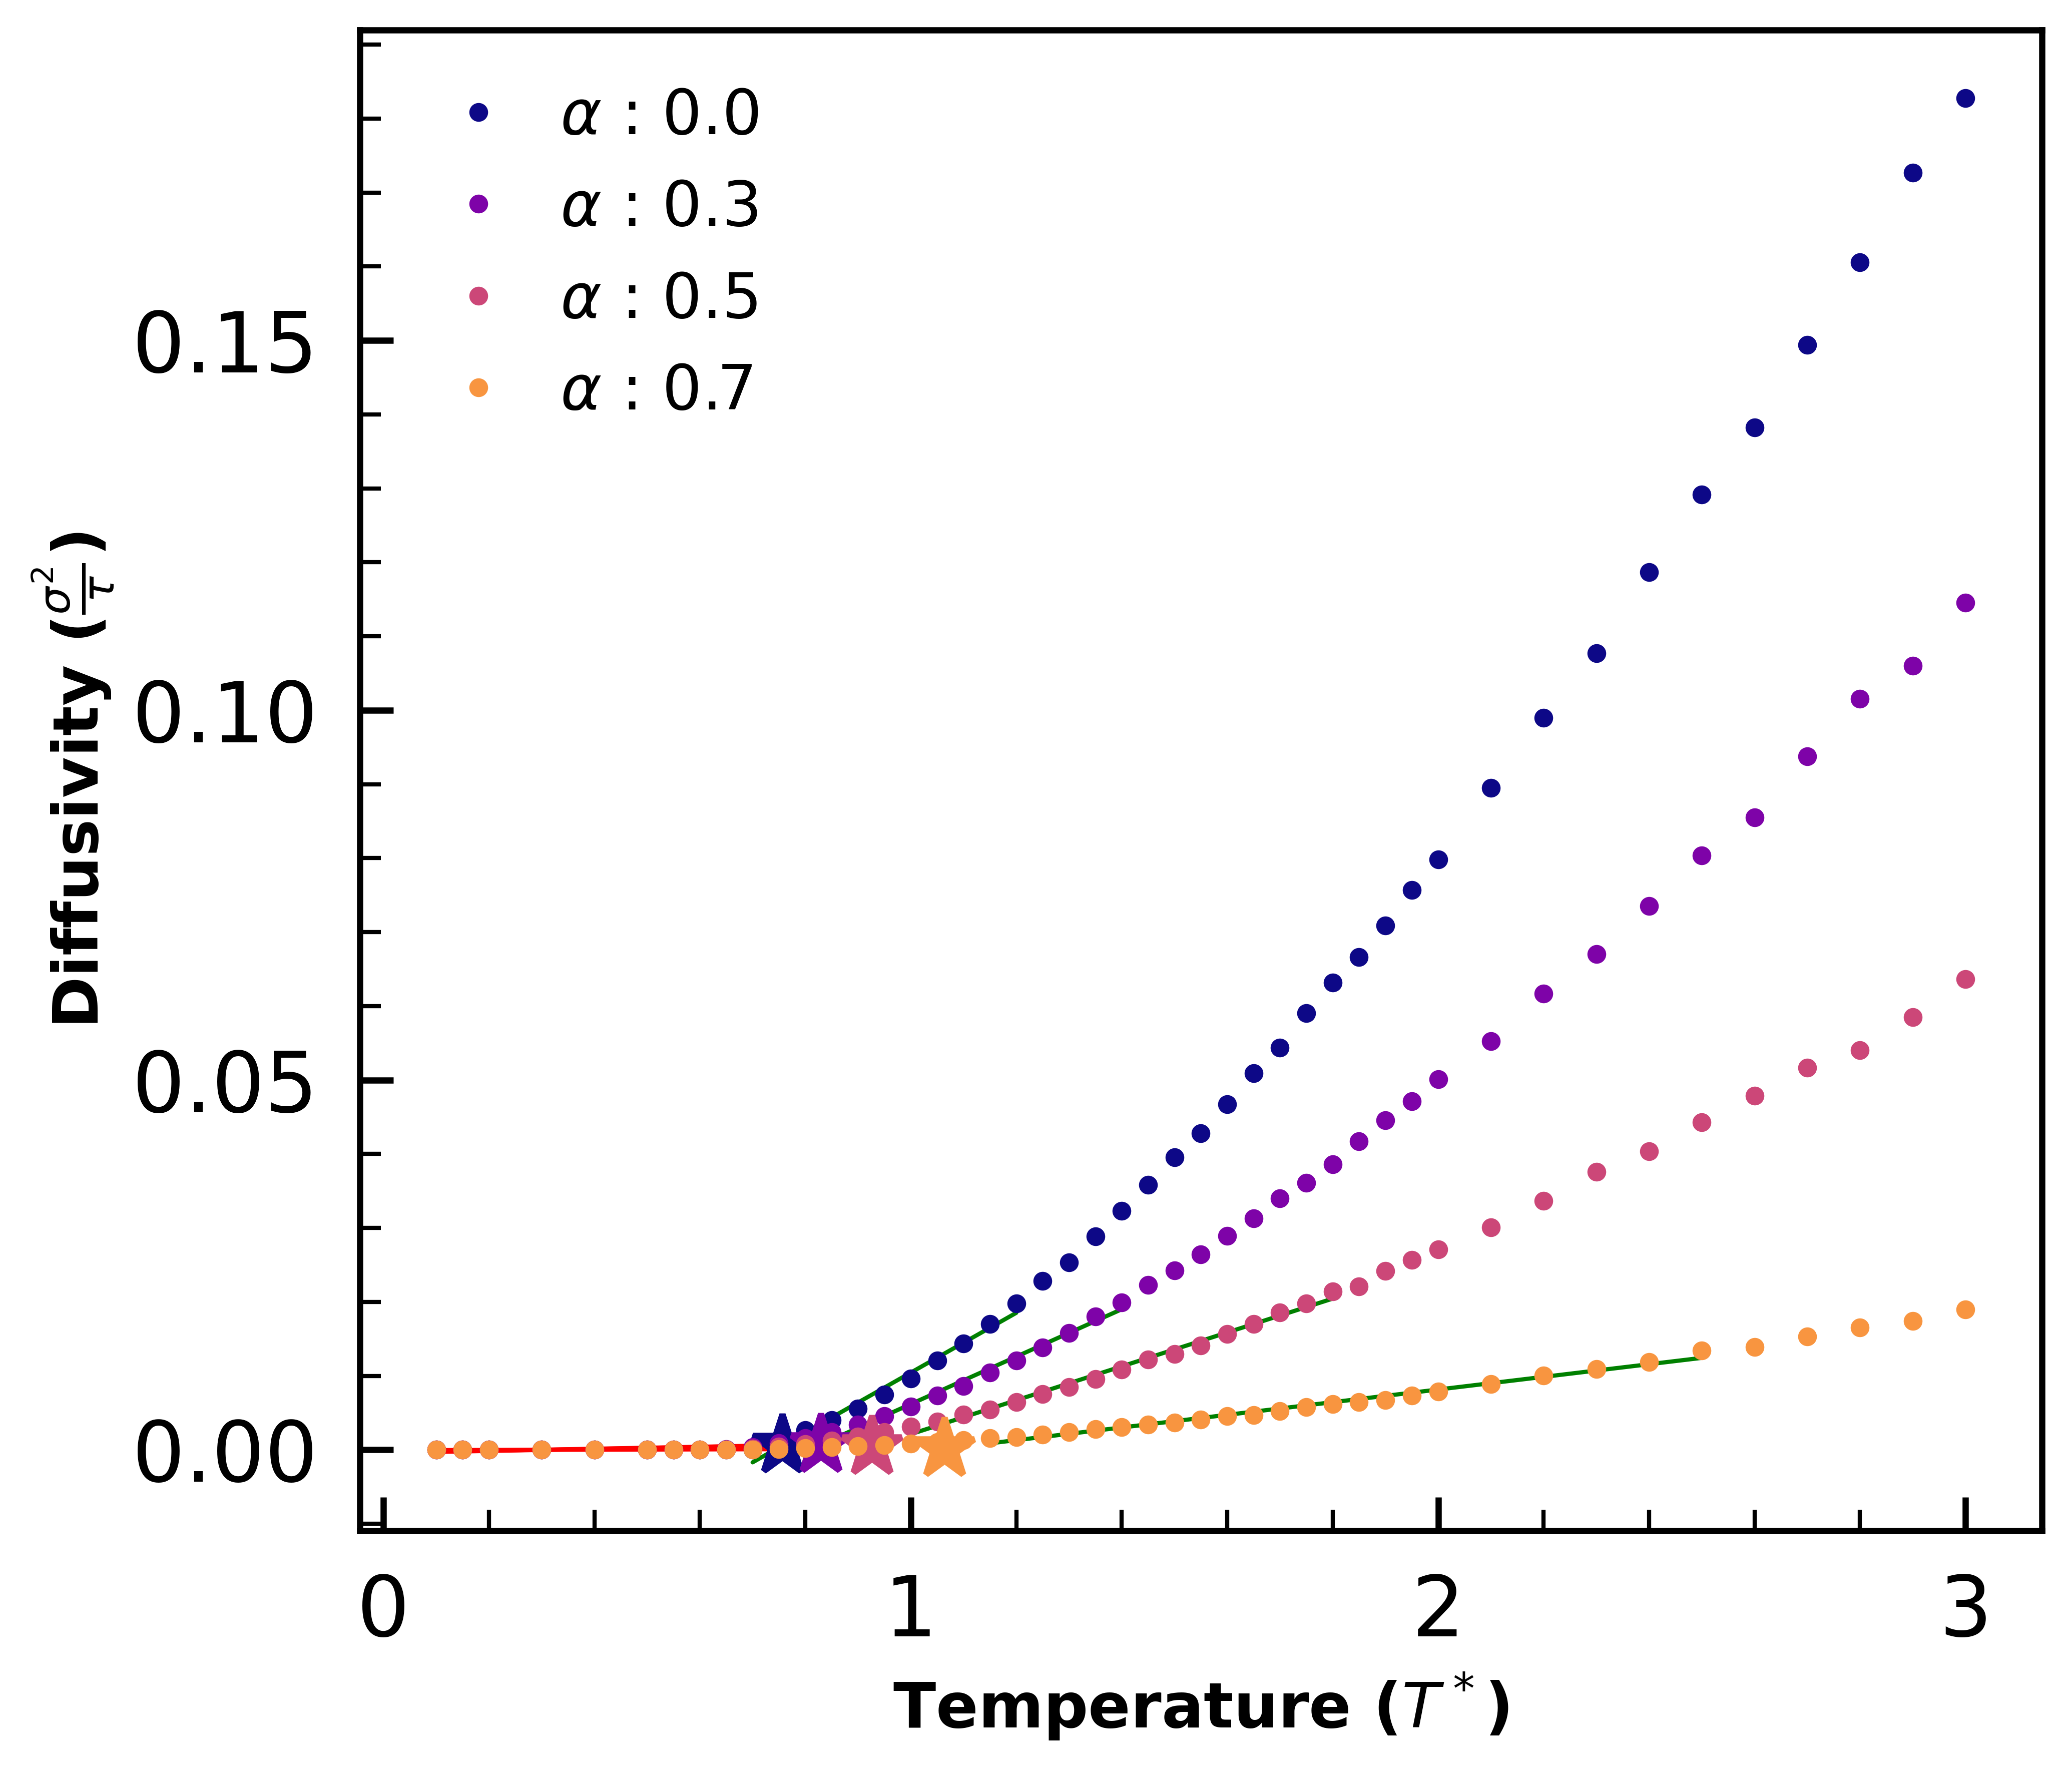

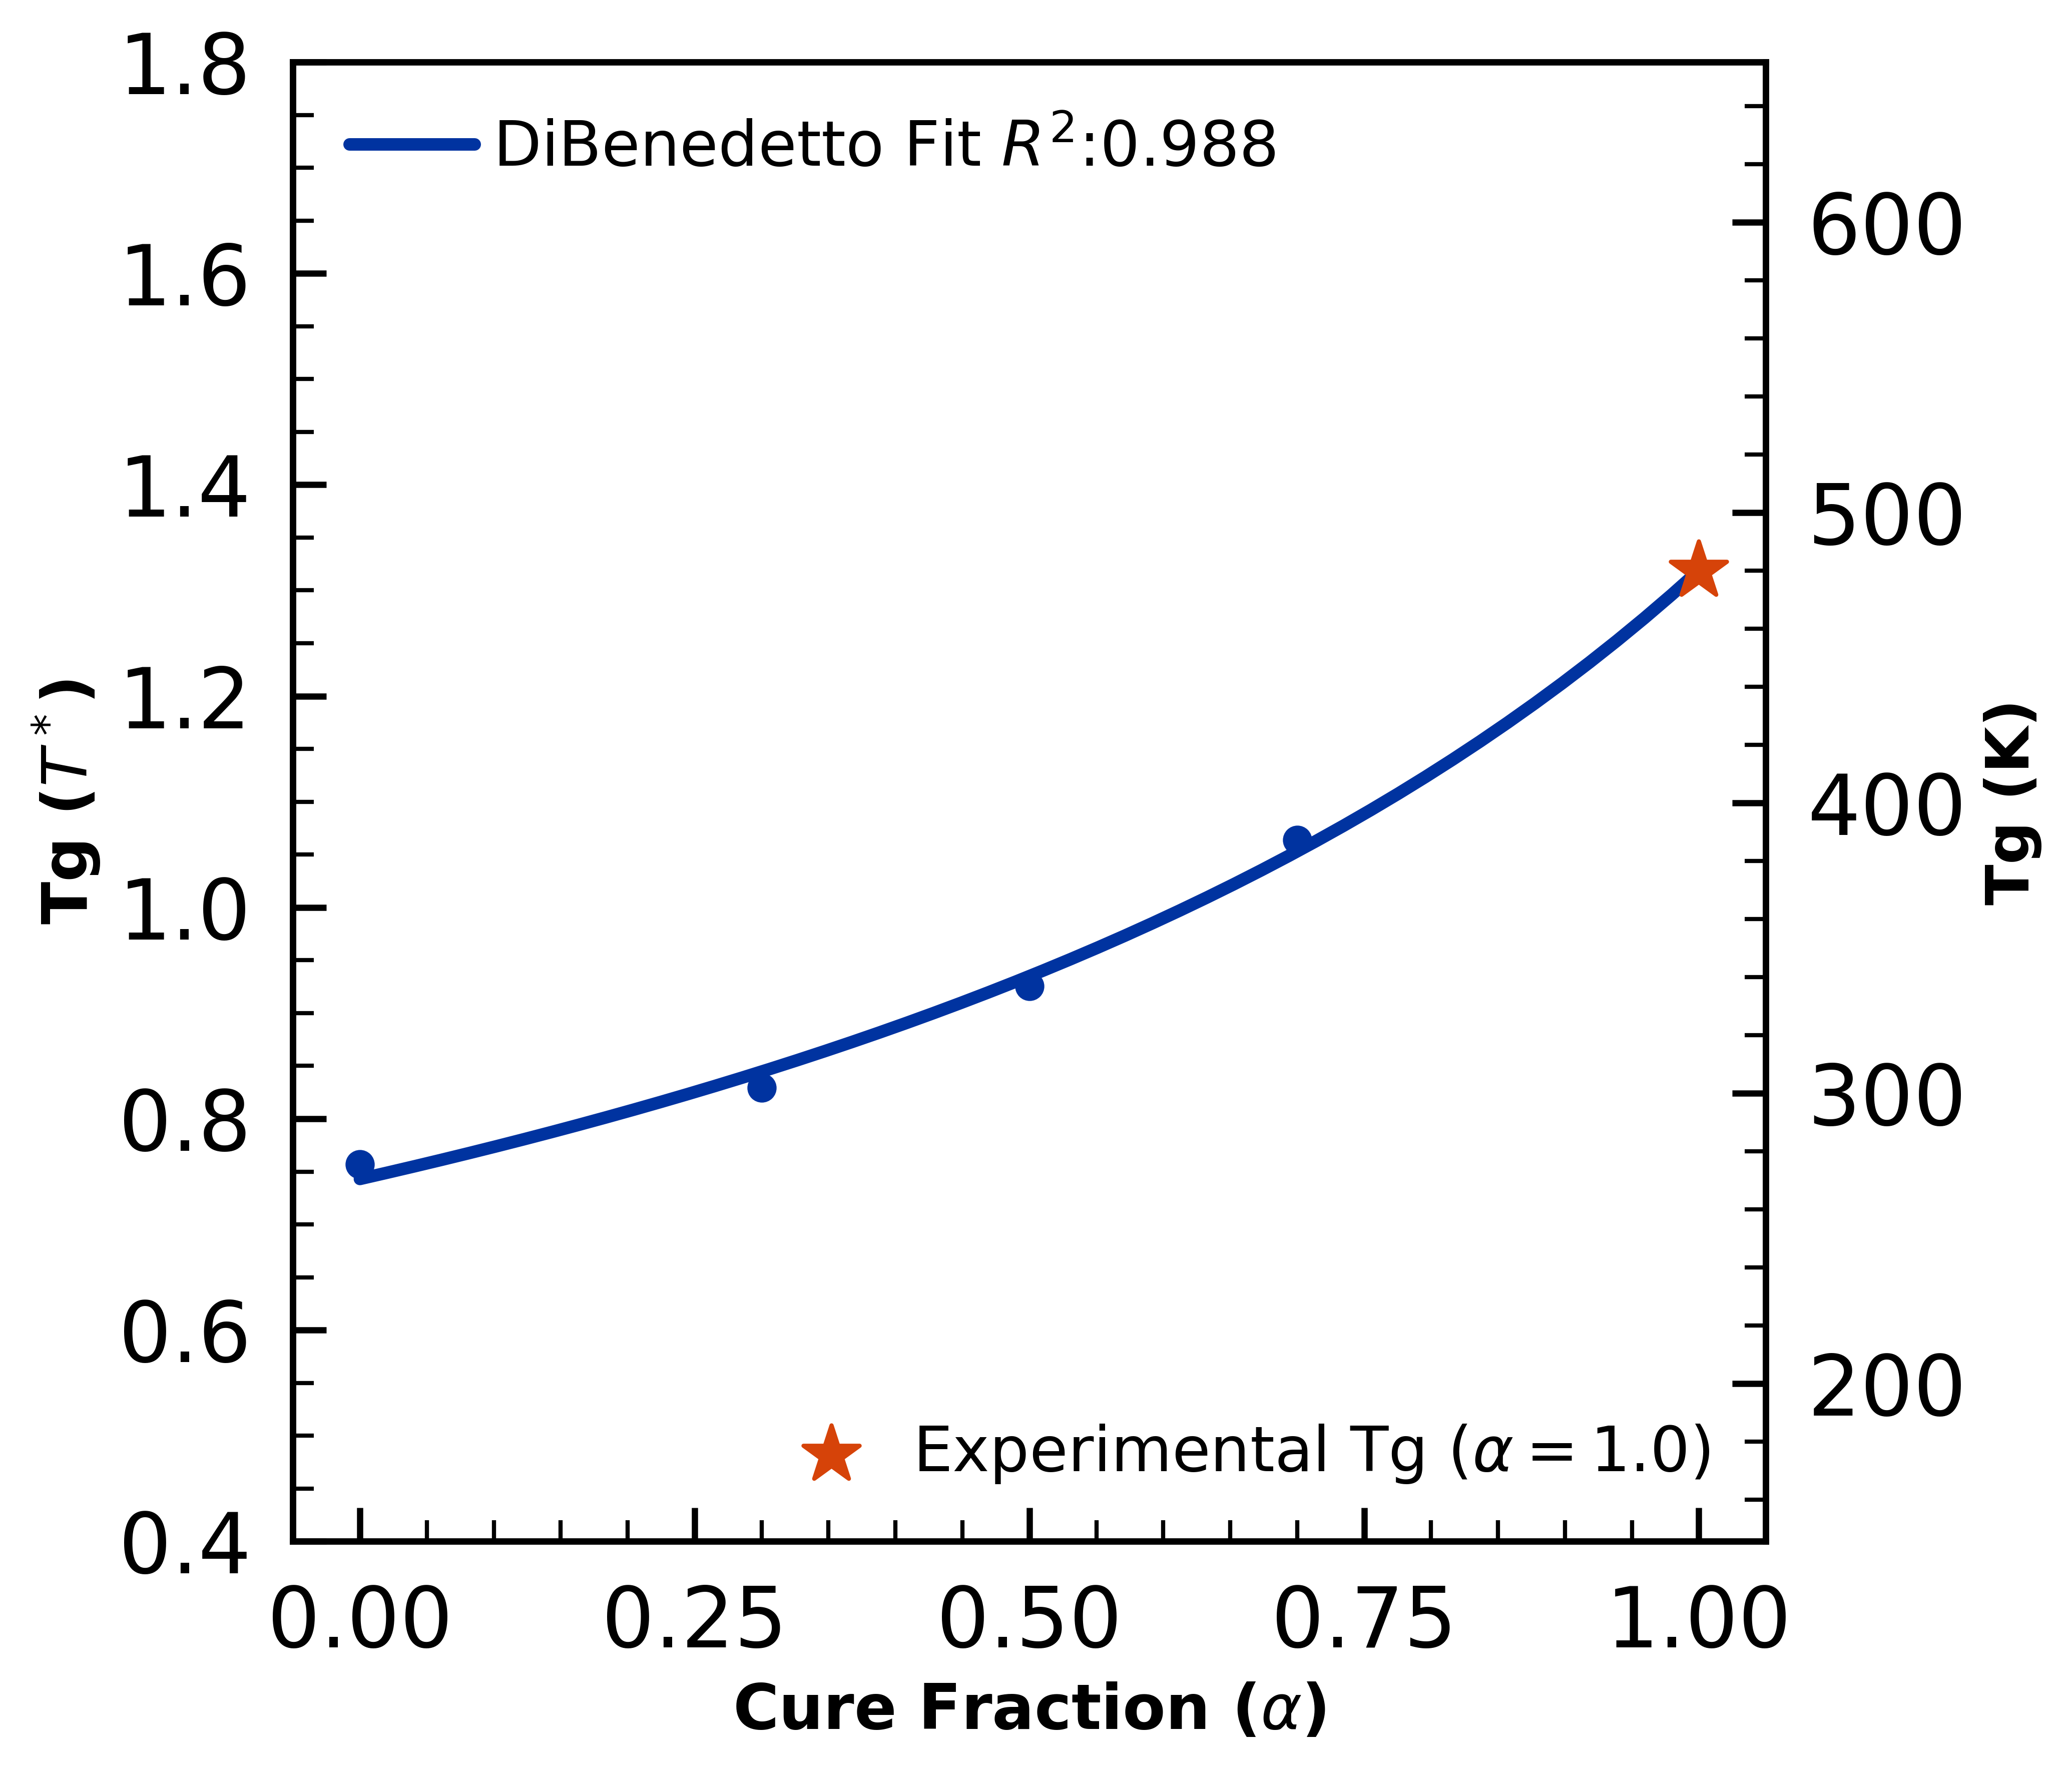

In [5]:
import os
os.environ['MATPLOTLIBRC'] = "../matplotlibrc" 
BSU_BLUE = "#0033A0"
BSU_ORANGE = "#D64309"

data_path = '/home/sthomas/projects/LB_mixing'

from common import getDiffusivities, line_intersect, fit_Tg_to_DiBenedetto, DiBenedetto, Fit_Diffusivity1

import signac
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib

from piecewise.regressor import piecewise #https://www.datadoghq.com/blog/engineering/piecewise-regression/
from piecewise.plotter import plot_data_with_regression
from scipy.signal import argrelextrema as argex
import matplotlib.cm as cm
import itertools

%matplotlib inline
names={'iso':'Isothermal','lin_ramp':'Linear Ramp','step':'Step'}
colors={'iso':'C0','lin_ramp':'C1','step':'C2'}
markers={'iso':'s','lin_ramp':'P','step':'>'}
linestyles={'iso':'-','lin_ramp':'--','step':'-.'}

project = signac.get_project(data_path)
df_index = pd.DataFrame(project.index())
df_index = df_index.set_index(['_id'])
statepoints = {doc['_id']: doc['statepoint'] for doc in project.index()}
df = pd.DataFrame(statepoints).T.join(df_index)
df = df.sort_values('T')
def get_custom_ranges(cooling_method):
    if cooling_method=='quench':
        custom_ranges_l1={00.0:[0.1,0.8],
                          30.0:[0.1,0.8],
                          50.0:[0.1,0.8],
                          70.0:[0.1,0.8]}
        custom_ranges_l2={00.0:[0.7,1.2],
                          30.0:[0.85,1.4],
                          50.0:[1.0,1.8],
                          70.0:[1.15,2.5]}
    elif cooling_method=='anneal':
        custom_ranges_l1={00.0:[0.1,0.8],
                          30.0:[0.1,0.8],
                          50.0:[0.1,0.8],
                          70.0:[0.1,0.8]}
        custom_ranges_l2={00.0:[0.7,1.2],
                          30.0:[0.85,1.4],
                          50.0:[1.0,1.8],
                          70.0:[1.15,2.5]}
    else:
        raise ValueError(cooling_method+'is unknown')
    return custom_ranges_l1, custom_ranges_l2

PROP_NAME ='bparticles'#'volume'#'pair_lj_energy','bond_harmonic_energy'#'potential_energy'
filter_saps=[0.0,30.,50.,70.]#,100.]#,100.]#[0.0,50.0,100.0]#,30,50,70]#,90]
colors = plt.cm.plasma(np.linspace(0,0.75,len(filter_saps)))
Tgs=[]
Tgs_tangent=[]
cure_percents = []
Cure_Ts=[]
markers=['+','.']
markersize=[10,10]
cooling_method='quench'
fig, ax1 = plt.subplots(dpi=600, figsize=(7,6))

df_filtered=df[(df.quench_T<=3.0)&
               (df.quench_T>=0.1)&
               (df.CC_bond_angle!=109.5)&
               (df.cooling_method==cooling_method)]#(df.quench_T<=3.0)&(df.quench_T>=0.05)&
for i,sap in enumerate(filter_saps):
    cooling_colors = plt.cm.plasma(np.linspace(0,0.75,2))
    for j,(cooling_method,df_grp) in enumerate(df_filtered.groupby('cooling_method')):
        df_curing = df_grp[(df_grp.bond==False)&
                       (df_grp.calibrationT==305)&
                       (df_grp.cooling_method==cooling_method)&
                       (df_grp.stop_after_percent==sap)]
        cure_percent = df_curing.cure_percent.mean()
        cure_percents.append(cure_percent)
        Ts,Ds=getDiffusivities(project,df_curing,name=PROP_NAME)
        Cure_Ts.append(Ts)
        
        mul_fact=1000000
        Ds_scaled=Ds*mul_fact
        custom_ranges_l1, custom_ranges_l2 = get_custom_ranges(cooling_method)
        print(custom_ranges_l1[sap])
        Tg,Tg_prop,line_vals = Fit_Diffusivity1(Ts,
                                  Ds_scaled,
                                  method='use_viscous_region',
                                  min_D=0,
                                  ver=4,
                                  viscous_line_index=0,
                                  l1_T_bounds=custom_ranges_l1[sap],
                                  l2_T_bounds=custom_ranges_l2[sap])
        xs = Ts#np.linspace(0.1,4)
        plt.plot(Tg,
                 Tg_prop/mul_fact,
                 marker='*',
                 color=colors[i],
                 markersize=15)#,
                    
        plt.plot(Ts,
                 Ds,
                 marker='.',
                 color=colors[i],#cooling_colors[j],
                 linewidth=0.0,
                 label='$\\alpha$ : {:.1f}'.format(sap/100))

        
        l_colors=['r','g']
        for li,line_val in enumerate(line_vals):
            xs=line_val[0]
            ys=line_val[1]/mul_fact
            plt.plot(xs,
                     ys,
                     color=l_colors[li],
                     zorder=0,
                     linewidth=1)
        Tgs.append(Tg)
    #break
plt.legend(fontsize=15)
plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))
Tgs = np.asarray(Tgs)
cure_percents = np.asarray(cure_percents)
data=[cure_percents,Tgs]

plt.xlabel('Temperature ($T^*$)',fontsize=15)
plt.ylabel('Diffusivity ($\\frac{\\sigma^2}{\\tau}$)',fontsize=15)


plt.savefig("some_alpha.png", transparent=True)

cure_percents = np.asarray(cure_percents)
fig, ax1 = plt.subplots(dpi=600, figsize=(7,6))
ax2=ax1.twinx()
Tgs = np.asarray(Tgs)
Tgs_tangent = np.asarray(Tgs_tangent)
print(Tgs)
Tg_data = np.asarray([cure_percents/100.,Tgs])
cure_percents_ss = cure_percents#[:-1]
Tgs_ss = Tgs#[:-1]
print(cure_percents_ss)
print(Tgs_ss)
R2,fit_Tgs,T1,inter_parm,T0 = fit_Tg_to_DiBenedetto(cure_percents_ss/100.,
                                                 Tgs_ss,
                                                 T1=None,
                                                 T0=None)
print('T1',T1,'lambda',inter_parm)
alphas = np.linspace(0,1)
fit_ydata = DiBenedetto(alphas,T1,T0=T0,inter_param=inter_parm)
ax1.plot(alphas,fit_ydata,label='DiBenedetto Fit $R^2$:{}'.format(round(R2,3)), color=BSU_BLUE)
ax1.scatter(cure_percents/100.,
            Tgs,
            color=BSU_BLUE)

Tg_sim = T1
Tg_exp = 480
roomT_exp = 300
Tex_toTsim = Tg_exp/Tg_sim
roomT_sim =  Tg_sim*roomT_exp/Tg_exp
Tg0_exp = Tg_exp*T0/Tg_sim
print('300 K in T*:',roomT_sim)
ax2.scatter(1.00,Tg_exp,marker='*',color=BSU_ORANGE,s=200,label='Experimental Tg ($\\alpha=1.0$)')
ax2.set_ylabel('Tg (K)')

sim_low_lim = 0.4
ex_low_lim = sim_low_lim*Tex_toTsim
sim_up_lim = 1.8
ex_up_lim = sim_up_lim*Tex_toTsim
ax2.set_ylim(ex_low_lim,ex_up_lim)
ax1.set_ylim(sim_low_lim,sim_up_lim)
show_roomT=False
if show_roomT:
    ax1.axhline(y=roomT_sim,linewidth=1.1,linestyle='--',label='simulated 300 K')
ax1.set_xlabel('Cure Fraction ($\\alpha$)',fontsize=15)
ax1.set_ylabel('Tg ($T^*$)',fontsize=15)
ax1.legend(fontsize=15,loc='upper left')
ax2.legend(fontsize=15,loc='lower right')
plt.ticklabel_format(axis='y',style='plain')
plt.savefig("DB_fit.png", transparent=True)